In [1]:
import os
os.chdir("..")


In [2]:
from skin_lesion_cad.utils.data_utils import get_class
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import time
import warnings
from pathlib import Path
mpl.rcParams['figure.dpi'] = 200


In [3]:
feature_dir = "data/processed/features"
CHALLENGE = "chall1"


In [4]:

def read_feats(color="raw"):
    save_path = Path("data/processed/features")

    glcm_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_glcm.feather"))
    lbp_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_lbp.feather"))

    glcm_masked_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_glcm_original_image.feather"))
    glcm_masked_df_train["image"] = glcm_masked_df_train["image"].apply(lambda x: x.replace(".jpg","_inpaint_0_5.png").replace("raw","processed"))
    
    # glcm_masked_df_train.columns = [
    #     "masked_"+i if i != "image" else i for i in glcm_masked_df_train.columns]

    lbp_masked_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_lbp_original_image.feather"))
    lbp_masked_df_train["image"] = lbp_masked_df_train["image"].apply(
        lambda x: x.replace(".jpg", "_inpaint_0_5.png").replace("raw", "processed"))
    shape_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_shape.feather"))

    # lbp_masked_df_train.columns = [
    #     "masked_"+i if i != "image" else i for i in lbp_masked_df_train.columns]

    color_df_raw_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_raw.feather"))
    color_df_ms_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_meanshift.feather"))

    glcm_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_glcm.feather"))
    lbp_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_lbp.feather"))
    shape_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_shape.feather"))

    glcm_masked_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_glcm_original_image.feather"))
    glcm_masked_df_val["image"] = glcm_masked_df_val["image"].apply(
        lambda x: x.replace(".jpg", "_inpaint_0_5.png").replace("raw", "processed"))

    # glcm_masked_df_val.columns = [
    #     "masked_"+i if i != "image" else i for i in glcm_masked_df_val.columns]

    lbp_masked_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_lbp_original_image.feather"))
    lbp_masked_df_val["image"] = lbp_masked_df_val["image"].apply(
        lambda x: x.replace(".jpg", "_inpaint_0_5.png").replace("raw", "processed"))

    # lbp_masked_df_val.columns = [
    #     "masked_"+i if i != "image" else i for i in lbp_masked_df_val.columns]

    color_df_raw_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_raw.feather"))
    color_df_ms_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_meanshift.feather"))

    dfs = [  # glcm_df_train, lbp_df_train,
        color_df_raw_train,
        glcm_masked_df_train, lbp_masked_df_train, shape_df_train]
    all_feat_raw_train = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_train, lbp_df_train, color_df_ms_train,
           glcm_masked_df_train, lbp_masked_df_train, shape_df_train]
    all_feat_ms_train = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [  # glcm_df_val, lbp_df_val,
        color_df_raw_val,
        glcm_masked_df_val, lbp_masked_df_val, shape_df_val]
    all_feat_raw_val = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_val, lbp_df_val, color_df_ms_val,
           glcm_masked_df_val, lbp_masked_df_val, shape_df_val]
    all_feat_ms_val = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)
    if color == "raw":
        return all_feat_raw_train, all_feat_raw_val
    elif color == "meanshift":
        return all_feat_ms_train, all_feat_ms_val


In [5]:
color = "raw"
all_feat_train, all_feat_val = read_feats("raw")

X_train = all_feat_train.drop(columns='image')
y_train = all_feat_train['image'].apply(get_class, chall=CHALLENGE)

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.3, random_state=42)
X_test = all_feat_val.drop(columns='image')
y_test = all_feat_val['image'].apply(get_class, chall=CHALLENGE)


In [6]:
all_feat_val


,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,extent,solidity,equi_diameter,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6
0,137.243668,20.733150,-1.374421,2.763821,179.0,28.0,9.766922,148.0,78.349388,22.284849,...,22269.383871,0.844844,148.610149,0.180003,0.002971,0.000439,4.058850e-05,5.411208e-09,2.188974e-06,2.235680e-10
1,137.499405,15.550008,-0.213844,-0.689362,177.0,89.0,8.802486,88.0,80.505676,21.261974,...,5432.196429,0.920242,91.266276,0.168145,0.002092,0.000023,1.739383e-07,2.046016e-13,4.300921e-09,-2.825537e-13
2,192.819809,4.511390,-0.479122,-0.120850,204.0,170.0,10.131265,35.0,115.868645,7.374851,...,7830.086124,0.761760,128.595627,0.300781,0.048966,0.005637,2.532540e-03,9.499641e-06,5.413295e-04,1.150532e-06
3,162.813477,4.207403,-0.758723,1.001030,181.0,146.0,8.937277,35.0,99.678047,18.988626,...,7517.835000,0.810380,90.449990,0.204662,0.007333,0.002475,1.523751e-04,3.261722e-08,-1.263919e-06,8.771421e-08
4,196.595490,7.001626,-5.151110,55.730215,214.0,84.0,10.153563,98.0,139.099609,11.827394,...,18569.512500,0.788865,179.049989,0.218590,0.012875,0.001274,3.206889e-05,-1.540852e-09,-3.585773e-06,6.295460e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,129.137451,9.451814,-0.463561,-0.896826,149.0,108.0,8.327426,42.0,63.055702,14.326772,...,3395.088889,0.851530,71.547604,0.181415,0.002695,0.001141,1.053994e-04,3.622981e-08,5.460645e-06,-4.785215e-09
3792,120.559052,29.065674,0.125570,-0.891309,201.0,51.0,9.756955,146.0,79.699081,29.552738,...,9159.071429,0.846305,149.208680,0.229371,0.023896,0.000909,2.314886e-04,9.380751e-08,2.771969e-05,-4.975874e-08
3793,145.874161,12.506536,-0.865735,0.459811,171.0,101.0,8.798738,70.0,92.185837,16.073589,...,3305.305085,0.759929,90.474621,0.367327,0.101497,0.000362,1.161623e-05,-4.312435e-10,-3.546616e-06,6.175578e-10
3794,152.494431,25.826296,-0.454049,-0.829902,192.0,53.0,12.075135,139.0,140.558899,31.727980,...,171245.586207,0.971804,475.209086,0.161561,0.000174,0.000015,8.591499e-07,-3.042797e-12,-1.021022e-08,6.194933e-14


In [7]:
all_feat_train.columns.values


array(['bgr_b_mean', 'bgr_b_std', 'bgr_b_skew', 'bgr_b_kurt', 'bgr_b_max',
       'bgr_b_min', 'bgr_b_entrp', 'bgr_b_unq', 'bgr_g_mean', 'bgr_g_std',
       'bgr_g_skew', 'bgr_g_kurt', 'bgr_g_max', 'bgr_g_min',
       'bgr_g_entrp', 'bgr_g_unq', 'bgr_r_mean', 'bgr_r_std',
       'bgr_r_skew', 'bgr_r_kurt', 'bgr_r_max', 'bgr_r_min',
       'bgr_r_entrp', 'bgr_r_unq', 'hsv_h_mean', 'hsv_h_std',
       'hsv_h_skew', 'hsv_h_kurt', 'hsv_h_max', 'hsv_h_min',
       'hsv_h_entrp', 'hsv_h_unq', 'hsv_s_mean', 'hsv_s_std',
       'hsv_s_skew', 'hsv_s_kurt', 'hsv_s_max', 'hsv_s_min',
       'hsv_s_entrp', 'hsv_s_unq', 'hsv_v_mean', 'hsv_v_std',
       'hsv_v_skew', 'hsv_v_kurt', 'hsv_v_max', 'hsv_v_min',
       'hsv_v_entrp', 'hsv_v_unq', 'lab_l_mean', 'lab_l_std',
       'lab_l_skew', 'lab_l_kurt', 'lab_l_max', 'lab_l_min',
       'lab_l_entrp', 'lab_l_unq', 'lab_a_mean', 'lab_a_std',
       'lab_a_skew', 'lab_a_kurt', 'lab_a_max', 'lab_a_min',
       'lab_a_entrp', 'lab_a_unq', 'lab_b_mean', 'l

In [8]:
X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0

X_test[np.isnan(X_test)] = 0
X_test[np.isinf(X_test)] = 0


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
xgb_params = {'base_score': 0.5,
              'booster': 'gbtree',
              'callbacks': None,
              'colsample_bylevel': 1,
              'colsample_bynode': 1,
              'colsample_bytree': 1,
              'early_stopping_rounds': None,
              'enable_categorical': False,
              'eval_metric': 'auc',
              'gamma': 0.4,
              'gpu_id': -1,
              'grow_policy': 'lossguide',
              'importance_type': None,
              'interaction_constraints': '',
              'learning_rate': 0.15,
              'max_bin': 256,
              'max_cat_to_onehot': 4,
              'max_delta_step': 0,
              'max_depth': 10,
              'max_leaves': 0,
              'min_child_weight': 1,
              'monotone_constraints': '()',
              'n_estimators': 100,
              'n_jobs': 0,
              'num_parallel_tree': 1,
              'objective': 'binary:logistic',
              'predictor': 'auto',
              'random_state': 0,
              'reg_alpha': 1.6,
              'reg_lambda': 3.2,
              'sampling_method': 'uniform',
              'scale_pos_weight': 1,
              'subsample': 1,
              'tree_method': 'hist',
              'use_label_encoder': False,
              'validate_parameters': 1,
              'verbosity': None}


In [11]:
xgb_best = xgb.XGBClassifier(**xgb_params)
xgb_best.fit(X_train, y_train.values.ravel())
#predictions - inputs to confusion matrix
train_predictions = xgb_best.predict(X_train)
test_predictions = xgb_best.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
print(accs_train)
print(accs_test)
print(cfm_test)


0.9993418887792037
0.8422023182297155
[[1613  318]
 [ 281 1584]]


In [70]:
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score

# svc = SVC(kernel='rbf', probability=True, class_weight='balanced', C=1.0)
# svc.fit(X_train, y_train)

# y_pred = svc.predict(X_test)

# print(classification_report(y_test, y_pred))
# print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
# print('\nAccuracy: ', accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1931
           1       0.81      0.83      0.82      1865

    accuracy                           0.82      3796
   macro avg       0.82      0.82      0.82      3796
weighted avg       0.82      0.82      0.82      3796

Confusion Matrix
 [[1572  359]
 [ 323 1542]]

Accuracy:  0.8203371970495258


In [71]:
# svc = SVC(kernel='rbf', probability=True,
#           class_weight='balanced', C=100, gamma=0.001)
# svc.fit(X_train, y_train)

# y_pred = svc.predict(X_test)

# print(classification_report(y_test, y_pred))
# print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
# print('\nAccuracy: ', accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1931
           1       0.85      0.85      0.85      1865

    accuracy                           0.85      3796
   macro avg       0.85      0.85      0.85      3796
weighted avg       0.85      0.85      0.85      3796

Confusion Matrix
 [[1641  290]
 [ 283 1582]]

Accuracy:  0.8490516332982087


In [14]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score


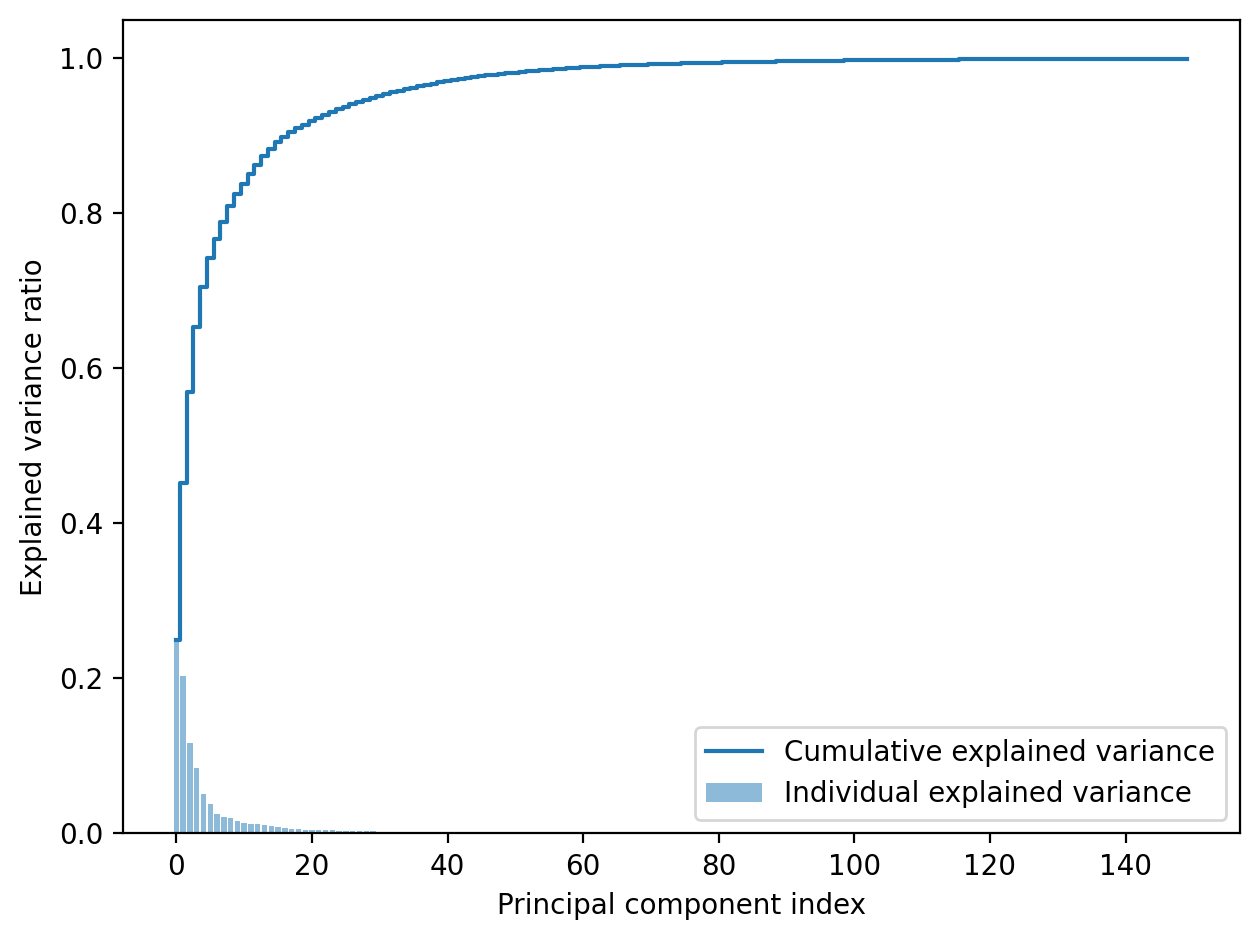

In [30]:
#
# Determine explained variance using explained_variance_ration_ attribute
#
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5,
        align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
         where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [45]:

svc = SVC(kernel='rbf', probability=True,
          class_weight='balanced', C=100, gamma=0.001)
svc.fit(X_train_pca, y_train)

y_pred = svc.predict(X_test_pca)
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
print('\nAccuracy: ', accuracy_score(y_test, y_pred))


Confusion Matrix
 [[1641  290]
 [ 283 1582]]

Accuracy:  0.8490516332982087


In [35]:
(cum_sum_eigenvalues<0.99).sum()

64

In [42]:
from tqdm import tqdm
# res_high = []
for n_components in tqdm(range(250,350,20)):

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    svc = SVC(kernel='rbf', probability=True,
            class_weight='balanced', C=100, gamma=0.001)
    svc.fit(X_train_pca, y_train)

    y_pred = svc.predict(X_test_pca)
    res.append((n_components, accuracy_score(y_test, y_pred)))
    # print(classification_report(y_test, y_pred))
#     print(f"n_components: {n_components}")
#     print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))
#     print('\nAccuracy: ', accuracy_score(y_test, y_pred))


100%|██████████| 5/5 [17:37<00:00, 211.47s/it]


Text(0, 0.5, 'Accuracy')

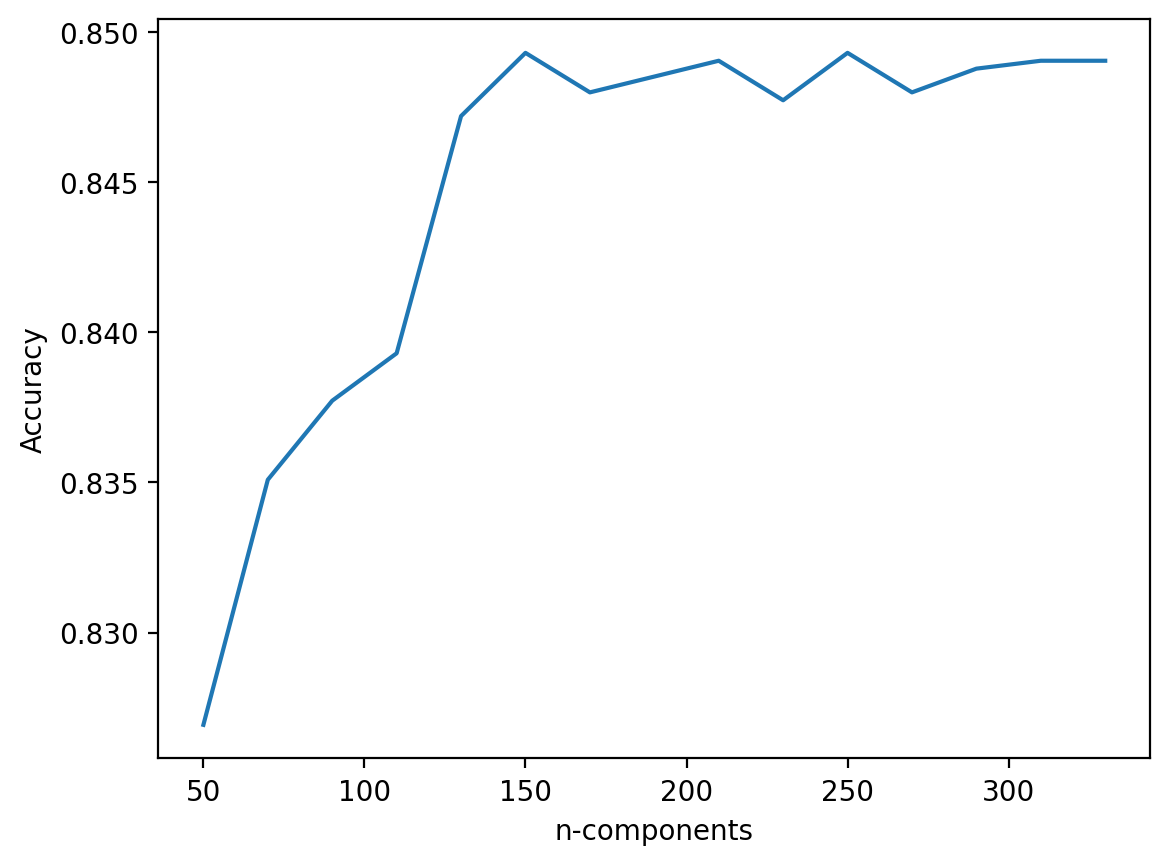

In [43]:
plt.plot(range(50,350,20),[i[1] for i in res])
plt.xlabel("n-components")
plt.ylabel("Accuracy")


In [44]:
res

[(50, 0.8269230769230769),
 (70, 0.8350895679662803),
 (90, 0.8377239199157007),
 (110, 0.839304531085353),
 (130, 0.8472075869336143),
 (150, 0.8493150684931506),
 (170, 0.8479978925184405),
 (190, 0.8485247629083246),
 (210, 0.8490516332982087),
 (230, 0.8477344573234984),
 (250, 0.8493150684931506),
 (270, 0.8479978925184405),
 (290, 0.8487881981032666),
 (310, 0.8490516332982087),
 (330, 0.8490516332982087)]